In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3Plus, MAnet, FPN
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils import train as smp_train
from segmentation_models_pytorch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler

from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore
from torchmetrics import Accuracy, F1Score, Precision, Recall, ConfusionMatrix, AUROC

import os
import cv2
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import echoregions as er

import warnings
from dask.diagnostics import ProgressBar
import math
import xarray as xr

from skimage.transform import resize

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SET UP INPUT/OUTPUT PATHS

In [3]:
zarr_dir = '/media/ubuntu/lenovops8/data/zarrs_norm' # normalized and depth corrected zarr files
img_dir = '/media/ubuntu/lenovops8/data/ML_data/imgs' # images as input for ML

# Structured info about zarr files
img_df = pd.DataFrame(columns = ['date', 'time_point', 'ind', 'path', 'zarr_path'])
for f in os.listdir(img_dir):
    time_point_str, _, ind_str = f.split('_')
    time_point = datetime.strptime(time_point_str, "D%Y%m%d-T%H%M%S")
    ind = int(ind_str.split('.')[0])
    date = time_point_str.split('-')[0][1:]
    img_df.loc[f] = [date, time_point, ind, os.path.join(img_dir, f), os.path.join(zarr_dir, f[:-6]+'.zarr')]
img_df.sort_values(by = ['time_point', 'ind'], inplace = True)

output_predictions = '/media/ubuntu/lenovops8/data/ML_data/predictions' # predictions the ML model in numpy format
zarr_masks_dir = '/media/ubuntu/lenovops8/data/zarrs_with_masks' # zarr files with masks as additional variable of xarrays
output_predictions_combined = '/media/ubuntu/lenovops8/data/ML_data/evr_combined' # evr files per day

img_df

,date,time_point,ind,path,zarr_path
D20190726-T041501_Sv_0.npy,20190726,2019-07-26 04:15:01,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20190...
D20190726-T044022_Sv_0.npy,20190726,2019-07-26 04:40:22,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20190...
D20190726-T050628_Sv_0.npy,20190726,2019-07-26 05:06:28,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20190...
D20190726-T053133_Sv_0.npy,20190726,2019-07-26 05:31:33,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20190...
D20190807-T152746_Sv_0.npy,20190807,2019-08-07 15:27:46,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20190...
...,...,...,...,...,...
D20191114-T094630_Sv_0.npy,20191114,2019-11-14 09:46:30,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20191...
D20191114-T102727_Sv_0.npy,20191114,2019-11-14 10:27:27,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20191...
D20191114-T110824_Sv_0.npy,20191114,2019-11-14 11:08:24,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20191...
D20191114-T114921_Sv_0.npy,20191114,2019-11-14 11:49:21,0,/media/ubuntu/lenovops8/data/ML_data/imgs/D201...,/media/ubuntu/lenovops8/data/zarrs_norm/D20191...


# LOAD MODEL

In [62]:
class SegModel(pl.LightningModule):
    def __init__(self, model, threshold = 0.5):
        """
        Initialize the SegModel.

        Parameters:
        - model: PyTorch model, the segmentation model to be used.
        - criterion: loss function.
        - optimizer: optimizer function.
        - threshold: float, threshold for converting probabilities to binary predictions. Default is 0.5.
        """
        super().__init__()
        self.model = model
        self.threshold = threshold

        self.iou = MeanIoU(num_classes=2, per_class=True)  
        self.precision = Precision(task="multiclass", num_classes=2, average='none')
        self.recall = Recall(task="multiclass", num_classes=2, average='none')
        self.f1 = F1Score(task="multiclass", num_classes=2, average='none')
        self.dice = GeneralizedDiceScore(num_classes=2, include_background=True, per_class=True)
        self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=2)
        self.auroc = AUROC(task="binary")

        self.test_outputs = []
        
    def forward(self, x):
        return self.model(x)

    def test_step(self, batch, batch_idx):
        """
        Test step to compute various metrics.

        Parameters:
        - batch: the input batch containing images and masks.
        - batch_idx: int, the index of the current batch.

        Returns:
        - dict: contains various metrics for the current batch.
        """
        x, y, _ = batch
        logits = self(x)
        preds = torch.sigmoid(logits) > self.threshold
        preds = preds.int()  # Convert boolean to integers
        y = y.int()  # Ensure targets are also integers

        self.precision.reset()
        self.recall.reset()
        self.f1.reset()
        self.iou.reset()
        
        # Update metrics
        iou_score = self.iou(preds, y)
        dice_score = self.dice(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        f1 = self.f1(preds, y)
        cm = self.confusion_matrix(preds, y).float()
        auroc = self.auroc(preds, y)

        outputs = {
            "iou": iou_score,
            "dice": dice_score,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm,
            "auroc": auroc
        }

        self.test_outputs.append(outputs)
        
        return outputs

    def on_test_epoch_end(self):
        """
        Aggregates metrics at the end of the test epoch and logs them.
        """
        iou_scores = torch.stack([x['iou'] for x in self.test_outputs])
        dice_scores = torch.stack([x['dice'] for x in self.test_outputs])
        precisions = torch.stack([x['precision'] for x in self.test_outputs])
        recalls = torch.stack([x['recall'] for x in self.test_outputs])
        f1_scores = torch.stack([x['f1'] for x in self.test_outputs])
        cm_scores = torch.stack([x['confusion_matrix'] for x in self.test_outputs])
        auroc_scores = torch.stack([x['auroc'] for x in self.test_outputs])
            
        # Sum confusion matrices
        sum_cm = cm_scores.sum(dim=0)
        sum_cm_np = sum_cm.cpu().numpy()  # Convert to numpy array
        cm_normalized = sum_cm_np.astype('float') / sum_cm_np.sum(axis=1)[:, np.newaxis]

        avg_auroc = auroc_scores.mean()

        avg_iou_background = iou_scores[:, 0].mean()
        avg_iou_class_of_interest = iou_scores[:, 1].mean()

        avg_dice_background = dice_scores[:, 0].mean()
        avg_dice_class_of_interest = dice_scores[:, 1].mean()
        
        avg_precision_background = precisions[:, 0].mean()
        avg_precision_class_of_interest = precisions[:, 1].mean()
        avg_recall_background = recalls[:, 0].mean()
        avg_recall_class_of_interest = recalls[:, 1].mean()
        avg_f1_background = f1_scores[:, 0].mean()
        avg_f1_class_of_interest = f1_scores[:, 1].mean()
    
        # Log aggregated metrics
        self.log('avg_auroc', avg_auroc)
        
        self.log('avg_iou_background', avg_iou_background)
        self.log('avg_iou_class_of_interest', avg_iou_class_of_interest)
        
        self.log('avg_dice_background', avg_dice_background)
        self.log('avg_dice_class_of_interest', avg_dice_class_of_interest)
        
        self.log('avg_precision_background', avg_precision_background)
        self.log('avg_precision_class_of_interest', avg_precision_class_of_interest)
        self.log('avg_recall_background', avg_recall_background)
        self.log('avg_recall_class_of_interest', avg_recall_class_of_interest)
        self.log('avg_f1_background', avg_f1_background)
        self.log('avg_f1_class_of_interest', avg_f1_class_of_interest)
    
        # Plot the normalized confusion matrix
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm_normalized, annot=True, fmt='.4f', cmap='Blues', xticklabels=['BG', 'Fish'], yticklabels=['BG', 'Fish'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Normalized Confusion Matrix')
        plt.show()
    
        # Clear the outputs for the next epoch
        self.test_outputs = []

    def save_preds(self, logits, batch_idx, output_dir, file_prefix):
        """
        Save predictions to the specified directory.

        Parameters:
        - logits: torch.Tensor, the logits output from the model.
        - batch_idx: int, the index of the current batch.
        - output_dir: str, directory where predictions will be saved.
        - file_prefix: str, prefix for the output file names (optional).
        """
        filename = str(batch_idx) + '.npy'
        if file_prefix:
            filename = file_prefix + '_' + filename
        pred_file_path = os.path.join(output_dir, filename)
        np.save(pred_file_path, logits.cpu())
        
    def predict(self, dataloader, device='cuda', output_dir=None, file_prefix=None):
        """
        Make predictions on a dataset and optionally save the results.

        Parameters:
        - dataloader: DataLoader, the DataLoader providing the images.
        - device: str, the device to use for computation. Default is 'cuda'.
        - output_dir: str, directory where predictions will be saved.
        - file_prefix: str, prefix for the output file names.
        """
        self.model.eval()

        if output_dir is None: 
            print('No output dir for predictions specified.')
            return

        with torch.no_grad():
            for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader), leave = False):
                images, _ = batch
                images = images.to(device)
                logits = self.model(images)
                self.save_preds(logits, batch_idx, output_dir, file_prefix)

class SonarTestDataset(Dataset):
    def __init__(self, data_paths, mask_paths=None, resize_size=512):
        """
        Initialize the SonarTestDataset.

        Parameters:
        - data_paths: list of str, paths to the image data files.
        - mask_paths: list of str, paths to the mask data files.
        - resize_size: int, the size to which the patches will be resized. Default is 512.
        """
        self.data_paths = data_paths
        self.mask_paths = mask_paths
        self.resize_size = resize_size
        
        # Transformations applied on the patches, NO IMAGENET
        #self.transforms = transforms.Compose([
        #    transforms.ToTensor(),
        #])

        # IMAGENET NORMALIZAZION
        self.transforms = transforms.Compose([
            transforms.ToTensor(),  # Applies only if your data is not already a tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        """
        Return the total number of patches in the dataset.
        """
        return len(self.data_paths)

    def __getitem__(self, idx):
        """
        Retrieve a patch and its corresponding mask by index.

        Parameters:
        - idx: int, the index of the patch to retrieve.

        Returns:
        - image_patch: torch.Tensor, the transformed image patch.
        - mask_patch: torch.Tensor, the transformed mask patch.
        """
        data_path = self.data_paths[idx]
        image = np.load(data_path, mmap_mode='r')
        # take only first 3 channels
        image = image[..., :3]

        if self.resize_size != image.shape[0]:
            image = cv2.resize(image, (self.resize_size, self.resize_size), interpolation=cv2.INTER_NEAREST)

        image = self.transforms(image.astype(np.float32))

        if self.mask_paths is not None:
            mask_path = self.mask_paths[idx]
            mask = np.load(mask_path, mmap_mode='r')
            if self.resize_size != image.shape[0]:
                mask = cv2.resize(mask, (self.resize_size, self.resize_size), interpolation=cv2.INTER_NEAREST)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        else:
            mask = torch.zeros((1, self.resize_size, self.resize_size), dtype=torch.float32)  

        return image, mask

In [63]:
batch_size = 4

# Loading pre-trained model
model_name = 'unet'
encoder = 'resnet34' 
pretrained =  'imagenet'

run_name = model_name + '_' + encoder
if pretrained: run_name += '_' + pretrained
 
classes = 1

model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         encoder_weights=pretrained,
                         classes = classes).to(device)
   
checkpoint_path = os.path.join(f'./models/checkpoints_{run_name}', 'best_model-v2.ckpt')
trained_model = SegModel.load_from_checkpoint(checkpoint_path, model=model)

# INFERENCE AND SAVING PREDICTIONS

In [65]:
torch.set_float32_matmul_precision('medium')

# iterate over days and save predictions into output_predictions
for date, rows in tqdm(img_df.groupby('date'), total = len(img_df.date.unique())):
    rows.sort_values(by='time_point', inplace = True)
    test_dataset = SonarTestDataset(rows.path.tolist())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    trained_model.predict(test_loader, output_dir = output_predictions, file_prefix = date)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

# Resize and save masks for each day

In [11]:
threshold = 0.5  # Threshold for converting logits to binary mask

def collect_day_predictions(date):
    # It's important that prediction files are sorted properly
    prediction_files = [f for f in os.listdir(output_predictions) if f.startswith(date)]
    prediction_files = [os.path.join(output_predictions, date+'_'+str(i)+'.npy') for i in range(0, len(prediction_files))]
    return prediction_files

def load_zarr_lazy(zarr_path, chunk_sizes={}):
    return xr.open_zarr(zarr_path, chunks=chunk_sizes)  

from scipy.ndimage import zoom
# resize masks to match the original xarray and save then together with xarray
def resize_save_masks(prediction_files, zarr_day_paths):
    counter = 0
    for pred_file in tqdm(prediction_files, total=len(prediction_files), leave = False):
        preds = np.load(pred_file)
        # binarize predictions
        masks = (preds > threshold).astype(int)
    
        for mask in masks:
            zarr_path = (zarr_day_paths[counter])
            mask = np.squeeze(mask)
            ds = load_zarr_lazy(zarr_path)

            # defined resize dimensions
            ping_times = ds['ping_time'].values
            depths = ds['depth'].values
            ping_size = len(ping_times)
            depth_size = len(depths)

            # resize masks
            scale_factors = (depth_size / mask.shape[0], ping_size / mask.shape[1])
            resized_mask = zoom(mask, scale_factors, order=2)
            # Threshold the result to keep it binary (0 or 1)
            resized_mask = (resized_mask > 0.5).astype(int)
            # masks are added as a variable to the original ds
            ds['mask'] = (('depth', 'ping_time'), resized_mask)
            # save masks as additional variable of original xarray
            ds.to_zarr(os.path.join(zarr_masks_dir, os.path.basename(zarr_path)), mode='w')
            counter+=1
            
def resize_date_masks(date):
    prediction_files = collect_day_predictions(date)
    zarr_day_paths = img_df[img_df.date == date].sort_values(by='time_point').zarr_path.values
    resize_save_masks(prediction_files, zarr_day_paths)

# This part is very slow, another solution needed

In [12]:
from concurrent.futures import ThreadPoolExecutor

# Get unique dates, only months 10 and 11, because for others there are no annotations
dates = img_df[(img_df.time_point.dt.month == 10) | (img_df.time_point.dt.month == 11)].date.unique()

with ThreadPoolExecutor(max_workers=4) as executor:
    list(tqdm(executor.map(resize_date_masks, dates), total=len(dates)))

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

# Generate EVR file

In [4]:
from scipy import ndimage
from skimage.measure import find_contours
from multiprocessing import Pool, cpu_count

# format YYYYMMDD HHSSMMMM
def format_time(point_time):
    """
    Format a datetime object into a string with the format YYYYMMDD HHSSMMMM.
    
    Parameters:
    point_time (datetime): A datetime object representing the point in time.
    
    Returns:
    str: Formatted time string.
    """
    microsecond = f"{point_time.microsecond:06d}"
    time_part = point_time.strftime("%H%M%S") + microsecond[:4]
    final_format = point_time.strftime("%Y%m%d ") + time_part
    return final_format

def process_region(args):
    """
    Process a single region to find its contours and generate metadata.
    
    Parameters:
    args (tuple): A tuple containing region_id, labeled_mask, ping_times, and depths.
    
    Returns:
    str: Formatted region metadata or None if no contours are found.
    """
    region_id, labeled_mask, ping_times, depths = args
    region_mask = (labeled_mask == region_id)
    contours = find_contours(region_mask, 0.5) # very slow functions
    
    if not contours:
        return None

    # Assuming the largest contour is the region boundary
    contour = max(contours, key=len)
    point_count = len(contour)
    
    # Region structure
    region_structure = []
    region_structure.append("13")
    region_structure.append(f"{point_count}")
    region_structure.append(f"{region_id}")
    region_structure.append("0")  # Selected
    region_structure.append("7")  # Region creation type (assuming "Detect Schools command")
    region_structure.append("-1")  # Dummy
    region_structure.append("1")  # Bounding rectangle calculated
    
    # Calculate bounding rectangle (x1, y1, x2, y2)
    depth_coords, ping_coords = np.where(region_mask)
    ping_left = ping_coords.min()
    ping_right = ping_coords.max()
    depth_top = depth_coords.min()
    depth_bottom = depth_coords.max()
    
    # Extract corresponding ping_time and depth
    left_time = datetime.utcfromtimestamp(ping_times[int(ping_left)].astype('datetime64[s]').astype(int))
    right_time = datetime.utcfromtimestamp(ping_times[int(ping_right)].astype('datetime64[s]').astype(int))
    left_time_str = format_time(left_time)
    right_time_str = format_time(right_time)

    depth_top = depths[int(depth_top)]
    depth_bottom = depths[int(depth_bottom)]

    region_structure.append(f"{left_time_str} {depth_top:.10f}")
    region_structure.append(f"{right_time_str} {depth_bottom:.10f}")
    
    region_content = []
    region_content.append(" ".join(region_structure))
    
    region_content.append("1")  # Number of lines of notes
    region_content.append("ML inference")  # Region notes
    region_content.append("0")  # Number of lines of detection settings
    region_content.append("Fish")  # Example classification
    
    # Points data
    points_str = []
    for point in contour:
        y, x = point
        point_time = datetime.utcfromtimestamp(ping_times[int(x)].astype('datetime64[s]').astype(int))
        point_time_str = format_time(point_time)
        depth_value = depths[int(y)]
        points_str.append(f"{point_time_str} {depth_value:.10f}")

    points_str.append("1")  # Region type (analysis)
    region_content.append(" ".join(points_str))
    
    # Region type and name
    region_content.append(f"Region{region_id}")

    return "\r\n".join(region_content)

def save_as_evr(mask, ping_times, depths, output_file, echoview_version="11.1.49.40912"):
    """
    Save the mask and region information as an EVR file.
    
    Parameters:
    mask (np.ndarray): Binary mask indicating regions.
    ping_times (np.ndarray): Array of ping times.
    depths (np.ndarray): Array of depth values.
    output_file (str): Path to the output file.
    echoview_version (str): Version of Echoview software.
    """
    # Identify regions in the mask
    labeled_mask, num_features = ndimage.label(mask)
    
    # Initialize EVR content with header
    evr_header = []
    evr_header.append(f"EVRG 7 {echoview_version}")
    evr_header.append(f"{num_features}")
    #evr_header.append("3")
    
    # Prepare arguments for parallel processing
    args = [(region_id, labeled_mask, ping_times, depths) for region_id in range(1, num_features+1)]
    
    with Pool(cpu_count()) as pool:
        region_contents = list(tqdm(pool.imap(process_region, args), total=num_features, leave = False))

    # Write to file in batch
    with open(output_file, 'w') as file:
        file.write("\r\n".join(evr_header))
        for region_content in region_contents:
            if region_content is not None:
                file.write("\r\n\n" + region_content)
                
def load_zarr_lazy(zarr_path, chunk_sizes={}):
    """
    Load a Zarr dataset lazily with specified chunk sizes and variables to ignore.
    
    Parameters:
    zarr_path (str): Path to the Zarr file.
    chunk_sizes (dict): Dictionary specifying chunk sizes for dimensions.
    ignore_vars (list): List of variables to ignore while loading.
    
    Returns:
    xarray.Dataset: Loaded Zarr dataset.
    """
    return xr.open_zarr(zarr_path, chunks=chunk_sizes) 

def generate_evr_date(date):
    zarr_mask_paths = [os.path.join(zarr_masks_dir, os.path.basename(zarr_path)) for zarr_path in img_df[img_df.date == date].sort_values(by='time_point').zarr_path.values]
    datasets = [load_zarr_lazy(path, chunk_sizes = {}) for path in zarr_mask_paths]
    combined_dataset = xr.concat(datasets, dim='ping_time')
    combined_dataset = combined_dataset.sortby('ping_time')
    ping_times = np.sort(combined_dataset['ping_time'].values)
    depths = np.sort(combined_dataset['depth'].values)
    
    # Define the output file path and save the EVR file
    output_file = os.path.join(output_predictions_combined, date + '.evr')
    save_as_evr(combined_dataset.mask.values, ping_times, depths, output_file)

# Also very slow and memory intensive

In [ ]:
# Get unique dates
dates = img_df.date.unique()

dates = ['20191018']

for date in tqdm(dates, total = len(dates)):
    generate_evr_date(date)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

# Visualization

In [5]:
date = '20191016'
evr_file = os.path.join(output_predictions_combined, date + '.evr')
regions2d = er.read_evr(evr_file)
region_classes = 'Fish'
regions_def = regions2d.select_region(region_class=region_classes)
zarr_day_paths = [os.path.join(zarr_dir, f) for f in os.listdir(zarr_dir) if f.startswith('D'+date)]
combined_dataset = [load_zarr_lazy(path, chunk_sizes = {}) for path in zarr_day_paths]
combined_dataset = xr.concat(combined_dataset, dim='ping_time')
combined_dataset = combined_dataset.sortby('ping_time')

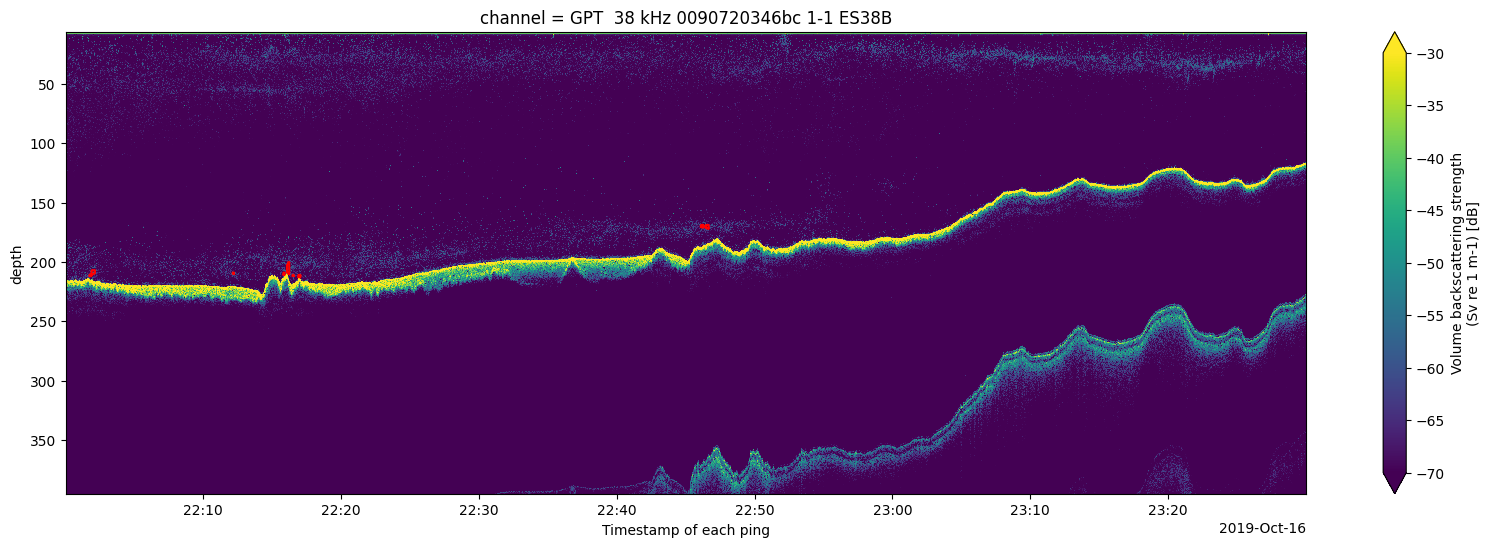

In [8]:
start_value = datetime.strptime("2019-10-16 22:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
end_value = datetime.strptime("2019-10-16 23:30:00.000", "%Y-%m-%d %H:%M:%S.%f")
start_value = np.datetime64(start_value)
end_value = np.datetime64(end_value)
start_index = np.searchsorted(combined_dataset['ping_time'].values, start_value)
end_index = np.searchsorted(combined_dataset['ping_time'].values, end_value)

# Plotting the echogram data and the school region
plt.figure(figsize=(20, 6))
for _, point in regions_def.iterrows():
    plt.plot(point["time"], point["depth"], fillstyle='full', markersize=50, color="red")

combined_dataset.Sv.isel(channel=1, ping_time=slice(start_index, end_index), depth=slice(0,2000)).T.plot(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap="viridis")

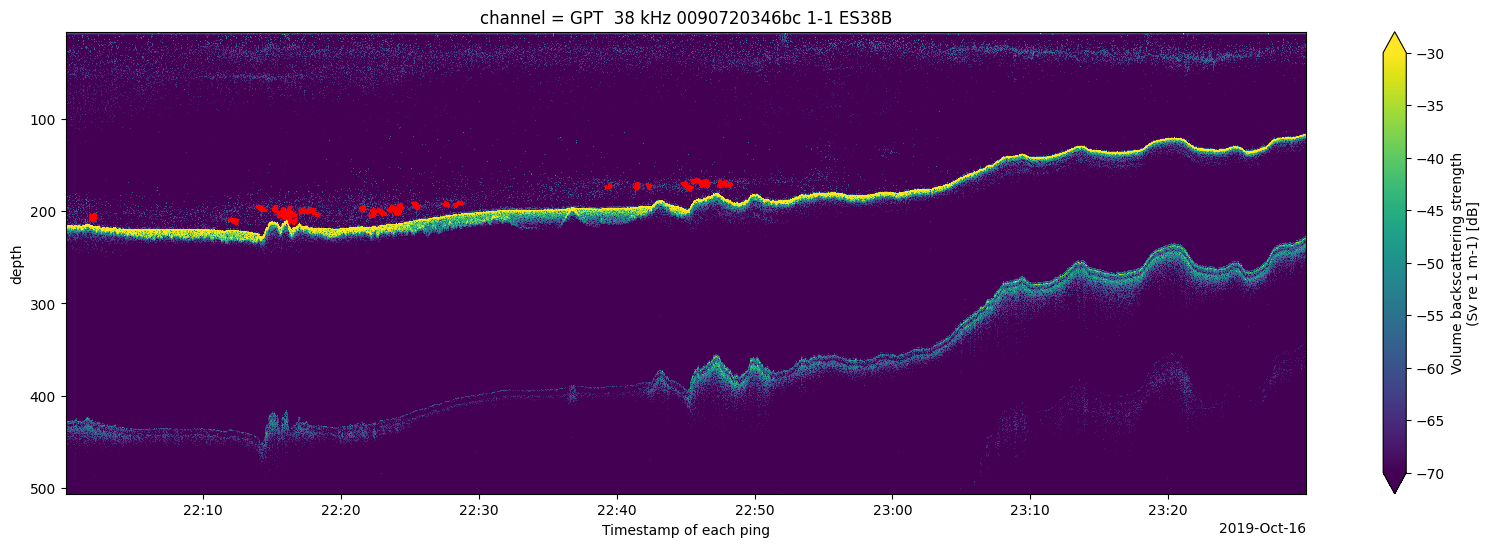

In [9]:
import pickle
evr_file = '/media/ubuntu/lenovops8/data/Annotations/annotations.pkl'
ann_df = pd.read_pickle(evr_file)
ann_df['region_bbox_left'] = pd.to_datetime(ann_df['region_bbox_left'], errors='coerce')
ann_df = ann_df[ann_df.region_class.isin(['atlantic_herring', 'possible_herring', 'AH_School'])]

plt.figure(figsize=(20, 6))
for _, point in ann_df[(ann_df.region_bbox_left >= start_value) & (ann_df.region_bbox_left <= end_value)].iterrows():
    plt.plot(point["time"], point["depth"], fillstyle='full', markersize=50, color="red")

combined_dataset.Sv.isel(channel=1, ping_time=slice(start_index, end_index)).T.plot(y="depth", yincrease=False, vmin=-70, vmax=-30, cmap="viridis")

In [13]:
# See which segments are annotate
ann_df[(ann_df.region_bbox_left.dt.year == 2019) & (ann_df.region_bbox_left.dt.month == 10) & (ann_df.region_bbox_left.dt.day == 16)].region_bbox_left

5    2019-10-16 15:17:34.280500
6    2019-10-16 16:23:34.126000
7    2019-10-16 17:23:17.754500
8    2019-10-16 17:15:16.079000
9    2019-10-16 20:17:25.541000
10   2019-10-16 20:32:02.562000
Name: region_bbox_left, dtype: datetime64[ns]

In [28]:
# See in which days there are most annotations
for month in range(1, 13):
    print('Month', month)
    print(ann_df[(ann_df.region_bbox_left.dt.year == 2019) & (ann_df.region_class == 'atlantic_herring') & 
        (ann_df.region_bbox_left.dt.month == month)].region_bbox_left.dt.day.value_counts())
    print()

Month 1
Series([], Name: count, dtype: int64)

Month 2
Series([], Name: count, dtype: int64)

Month 3
Series([], Name: count, dtype: int64)

Month 4
Series([], Name: count, dtype: int64)

Month 5
Series([], Name: count, dtype: int64)

Month 6
Series([], Name: count, dtype: int64)

Month 7
Series([], Name: count, dtype: int64)

Month 8
Series([], Name: count, dtype: int64)

Month 9
Series([], Name: count, dtype: int64)

Month 10
region_bbox_left
18    8
16    6
31    5
19    5
22    4
24    3
23    3
13    1
14    1
Name: count, dtype: int64

Month 11
region_bbox_left
1     10
9      6
2      6
12     6
7      5
11     5
4      5
6      4
10     3
8      3
13     3
5      2
3      2
Name: count, dtype: int64

Month 12
Series([], Name: count, dtype: int64)

